In [1]:
import mfem.ser as mfem
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class InitialCondition(mfem.PyCoefficient):
    def EvalValue(self, x):
        if 0.26 < x[0] < 0.57:
            return (np.sin(2 * np.pi * (x[0] - 0.26)/ 0.31 ))**2        
        else:
            return .0

        
#вектор
class VelocityCoefficient(mfem.VectorPyCoefficient):
    def __init__(self):
        super().__init__(1) #размерность пространства - 1D
    #возвращает константное значение вектора в каждой точке 

    def EvalValue(self, x):
        return [0.96]
    
    
class ConvectionOperator(mfem.PyTimeDependentOperator):
    def __init__(self, fespace, kappa, alpha, u, rel_tol=1e-9, max_iter_m=40, max_iter_t=100):

        super().__init__(fespace.GetTrueVSize(), 0.0)
        self.fespace = fespace
        self.kappa = kappa
        self.alpha = alpha

        self.z = mfem.Vector(self.Height())
        self.ess_tdof_list = mfem.intArray()

        self.M_solver, self.T_solver = None, None
        self.M_prec, self.T_prec = None, None
        self.Solvers(rel_tol, max_iter_m, max_iter_t)

        self.Mmat, self.Dmat, self.Cmat = None, None, None
        self.MassMatrix()
        self.ConvectionMatrix()
        self.DiffusionMatrix(u)

    def Solvers(self, rel_tol, max_iter_m, max_iter_t):
        self.M_solver = mfem.CGSolver()
        self.M_prec = mfem.DSmoother()
        self.SolverConfig(self.M_solver, self.M_prec, rel_tol, max_iter_m)

        self.T_solver = mfem.CGSolver()
        self.T_prec = mfem.DSmoother()
        self.SolverConfig(self.T_solver, self.T_prec, rel_tol, max_iter_t)

    def SolverConfig(self, solver, preconditioner, rel_tol, max_iter):
        solver.iterative_mode = False
        solver.SetRelTol(rel_tol)
        solver.SetAbsTol(0.0)
        solver.SetMaxIter(max_iter)
        solver.SetPrintLevel(0)
        solver.SetPreconditioner(preconditioner)

    def MassMatrix(self):
        self.M = mfem.BilinearForm(self.fespace)
        self.M.AddDomainIntegrator(mfem.MassIntegrator())
        self.M.Assemble()
        self.Mmat = mfem.SparseMatrix()
        self.M.FormSystemMatrix(self.ess_tdof_list, self.Mmat)
        self.M_solver.SetOperator(self.Mmat)

    def ConvectionMatrix(self):
        velocity_coeff = VelocityCoefficient()
        self.C = mfem.BilinearForm(self.fespace)
        self.C.AddDomainIntegrator(mfem.ConvectionIntegrator(velocity_coeff))
        self.C.Assemble()
        self.Cmat = mfem.SparseMatrix()
        self.C.FormSystemMatrix(self.ess_tdof_list, self.Cmat)

    def DiffusionMatrix(self, u):
        self.u_alpha = mfem.GridFunction(self.fespace)
        self.u_coeff = mfem.GridFunctionCoefficient(self.u_alpha)
        self.D = mfem.BilinearForm(self.fespace)
        self.D.AddDomainIntegrator(mfem.DiffusionIntegrator(self.u_coeff))

        for i in range(self.u_alpha.Size()):
            self.u_alpha[i] = self.kappa + self.alpha * u[i]

        self.D.Assemble()
        self.Dmat = mfem.SparseMatrix()
        self.D.FormSystemMatrix(self.ess_tdof_list, self.Dmat)

    def Mult(self, u, du_dt):
        tmp = mfem.Vector(self.Height())
        self.Cmat.Mult(u, tmp)
        self.Dmat.Mult(u, self.z)
        self.z.Add(1.0, tmp)
        self.z.Neg()
        self.M_solver.Mult(self.z, du_dt)

In [12]:
L = 1.0
num_elements = 500

mesh = mfem.Mesh.MakeCartesian1D(num_elements, L)
print(mesh.PrintInfo())

print([i for i in mesh.bdr_attributes])
print([i for i in mesh.attributes])

None
[1, 2]
[1]
Mesh Characteristics:
Dimension          : 1
Space dimension    : 1
Number of vertices : 501
Number of elements : 500
Number of bdr elem : 2
h_min              : 0.002
h_max              : 0.002



In [13]:
order = 1
fec = mfem.H1_FECollection(order, mesh.Dimension())
fespace = mfem.FiniteElementSpace(mesh, fec)

#Проекция начального условия
u = mfem.GridFunction(fespace)
u.ProjectCoefficient(InitialCondition())


oper = ConvectionOperator(fespace, alpha=0.098, kappa=0.036, u=u)
ode_solver = mfem.RK2Solver()
ode_solver.Init(oper)

verts = mesh.GetVertexArray()

t = .0
ti = 0
vis_steps = 1000

t_final = 0.6
dt = 0.000005

results = []
results.append(np.array(u.GetDataArray()))

while True:
    if t > t_final - dt/2:
        break
    t, dt = ode_solver.Step(u, t, dt)
    ti = ti + 1

    if ti % vis_steps == 0:
        print("time step: " + str(ti) + ", time: " + str(np.round(t, 3)))
        results.append(np.array(u.GetDataArray()))
        

time step: 1000, time: 0.005
time step: 2000, time: 0.01
time step: 3000, time: 0.015
time step: 4000, time: 0.02
time step: 5000, time: 0.025
time step: 6000, time: 0.03
time step: 7000, time: 0.035
time step: 8000, time: 0.04
time step: 9000, time: 0.045
time step: 10000, time: 0.05
time step: 11000, time: 0.055
time step: 12000, time: 0.06
time step: 13000, time: 0.065
time step: 14000, time: 0.07
time step: 15000, time: 0.075
time step: 16000, time: 0.08
time step: 17000, time: 0.085
time step: 18000, time: 0.09
time step: 19000, time: 0.095
time step: 20000, time: 0.1
time step: 21000, time: 0.105
time step: 22000, time: 0.11
time step: 23000, time: 0.115
time step: 24000, time: 0.12
time step: 25000, time: 0.125
time step: 26000, time: 0.13
time step: 27000, time: 0.135
time step: 28000, time: 0.14
time step: 29000, time: 0.145
time step: 30000, time: 0.15
time step: 31000, time: 0.155
time step: 32000, time: 0.16
time step: 33000, time: 0.165
time step: 34000, time: 0.17
time st

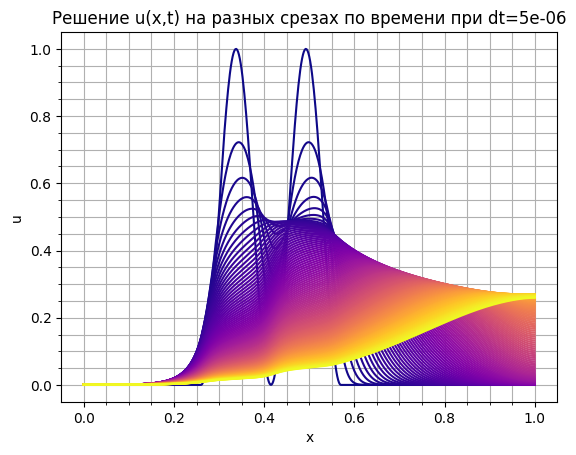

501 121


In [10]:
cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0, 1, len(results)))

fig, ax = plt.subplots()
ax.minorticks_on()
ax.grid(which='both')
ax.set(xlabel="x", ylabel="u")
tit = ax.set_title(f"Решение u(x,t) на разных срезах по времени при dt={dt}")

for sol, color in zip(results, colors):
    ax.plot(verts, sol, color=color)
plt.savefig(f"resultsss_dt={dt}.png")
plt.show()

print(len(verts), len(results))